# Wastewater to Predict COVID in Ottawa
COMP 3106 Project Code 

### Authors 
Kyle Knobloch & Yuxiao Chen 

### Data

Waste Water Data: https://github.com/Big-Life-Lab/PHESD

Ottawa Testing Data: https://www.arcgis.com/home/item.html?id=26c902bf1da44d3d90b099392b544b81 

### Methodologies

* Linear Model and Gradient Descend
* Random Forest Regressor

## Data Manipulation

In [ ]:
import numpy as np
import math
import requests
import matplotlib as plot
import matplotlib.pyplot as plt
%matplotlib inline
from io import StringIO
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Download wastewater
# covN1: SARS-CoV-2 nucleocapsid gene N1 normalized with nPMMoV: Pepper mild mottle virus
# covN2: SARS-CoV-2 nucleocapsid gene N2 normalized with nPMMoV: Pepper mild mottle virus
# Added together gets the waste water value
# https://github.com/Big-Life-Lab/PHES-ODM/blob/main/metadata_en.md
wasterwater_url = 'https://raw.githubusercontent.com/Big-Life-Lab/PHESD/main/Wastewater/Ottawa/Data/wastewater_virus.csv'
ww_r = requests.get(wasterwater_url).text
wastewater = np.genfromtxt(StringIO(ww_r), delimiter=",", dtype=None, encoding=None)


# Download covid testing 
covid_testing_url = 'https://www.arcgis.com/sharing/rest/content/items/26c902bf1da44d3d90b099392b544b81/data'
covid_r = requests.get(covid_testing_url).text
covid_r = covid_r.replace('"Date","Number of Tests, Excluding LTCH","Daily % Positivity, Excluding LTCH","Number of Tests in LTCH","LTCH Daily % Positivity"', 
                          '"Date","Number of Tests Excluding LTCH","Daily % Positivity Excluding LTCH","Number of Tests in LTCH","LTCH Daily % Positivity"')
covidtests = np.genfromtxt(StringIO(covid_r), delimiter=",", dtype=None, encoding=None)


# Covert covid tests into combined data
covid_totals = []
for i in covidtests:
  if i[0] == '"Date"':
    covid_totals.append(["Total positive"])
  else:
    covid_totals.append([int((float(i[1]) * float(i[2]) * 0.01) + (float(i[3]) * float(i[4]) * 0.01))])

covidtests = np.append(covidtests, covid_totals, axis=1)


# Create different datasets

# Data with data
date_ww_covid = []
date_ww_covid.append(["date", "wastewater level", "covid count positive on that day"])

# Data without date
ww_covid = []
ww_covid.append(["wastewater level", "covid count positive on that day"])

# Two wastewater values and one covid test value, no date
waste2_covid = []
#ww2_covid.append(["wastewater level covid1", "wastewater level covid2", "wastewater[9]"])

# Wastewater means 1 and 2, covid positve case count
waste3_covid = []
#ww3_covid.append("wastewater level1", "wastewater level2", "covid count positive on that day"])


# Assemble the datasets 

ww_count = 1 # ww count
co_count = 1 # covid count 
while True: 
  if co_count >= len(covidtests) or ww_count >= len(wastewater):
    break

  # covid testing started before ww testing
  if covidtests[co_count][0].replace('"','') == wastewater[ww_count][0]:
    # WITH DATE
    date_ww_covid.append([wastewater[ww_count][0], float(wastewater[ww_count][5]) + float(wastewater[ww_count][7]), float(covidtests[co_count][5])])
    # NO DATE
    ww_covid.append([float(wastewater[ww_count][5]) + float(wastewater[ww_count][7]), float(covidtests[co_count][5])])
    # ww2_covid updated to exclude the covid counts for the linear regression.                                                                         
    waste2_covid.append([float(wastewater[ww_count][5]), float(wastewater[ww_count][7]),float(wastewater[ww_count][9])])
    # NO DATE + seperate ww
    waste3_covid.append([float(wastewater[ww_count][5]), float(wastewater[ww_count][7]), float(covidtests[co_count][5])])
    ww_count = ww_count + 1
  # Always increment 
  co_count = co_count + 1


# Convert data to NumPy array

ww_covid = np.array(ww_covid)
waste2_covid = np.array(waste2_covid)
date_ww_covid = np.array(date_ww_covid)


# Splitting the data in to test and train 

x = [float(d[0]) for d in ww_covid[1:]]
y = [float(d[1]) for d in ww_covid[1:]]

# x = WW, y = covid
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=4)
w = [float(d[0]) for d in waste2_covid]
x = [float(d[1]) for d in waste2_covid]
y = [float(d[2]) for d in waste2_covid]
wx = []
for index in range(len(w)):
  wx.append([w[index], x[index]])

# x = [WW,WW_2], y = covid, 
x_train2, x_test2, y_train2, y_test2 = train_test_split(wx, y, random_state=4)

# Training data to NumPy Array
x_train = np.asarray(x_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)


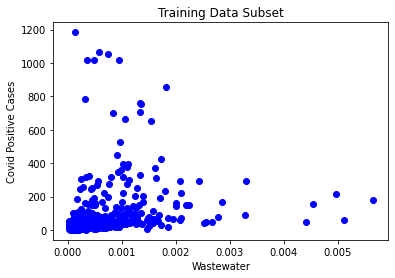

In [ ]:
# Show the data in its raw format. 
plt.title("Training Data Subset")
plt.xlabel("Wastewater")
plt.ylabel("Covid Positive Cases")
plt.plot(x_train, y_train, 'bo')

## Linear Regression Model

This graph shows that our error rate is super high. Our linear model needs to be improved on.



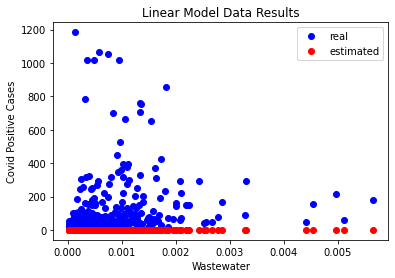

In [ ]:
# Test the initial, random model 
p_x = torch.from_numpy(x_train)
p_y = torch.from_numpy(y_train)

# Define w and b
# w = weight
# b = bias
w = Variable(torch.randn(1), requires_grad=True) # randomly initialize weight
b = Variable(torch.zeros(1), requires_grad=True) # intialize as 0

# Linear regression model
p_x_var = Variable(p_x)
p_y_var = Variable(p_y)

def linear_model(x):
    return x * w + b

linear_y = linear_model(p_x_var)
plt.title("Linear Model Data Results")
plt.xlabel("Wastewater")
plt.ylabel("Covid Positive Cases")
plt.plot(p_x_var.data.numpy(), p_y_var.data.numpy(), 'bo', label='real')
plt.plot(p_x_var.data.numpy(), linear_y.data.numpy(), 'ro', label='estimated')
plt.legend()
print("This graph shows that our error rate is super high. Our linear model needs to be improved on.\n")

In [ ]:
# Calculate the loss
def get_loss(linear_y, y):
    return torch.mean((linear_y - p_y_var) ** 2)

loss = get_loss(linear_y, y_train)
print(loss)
# get the derivative
loss.backward()

tensor(35241.9023, grad_fn=<MeanBackward0>)


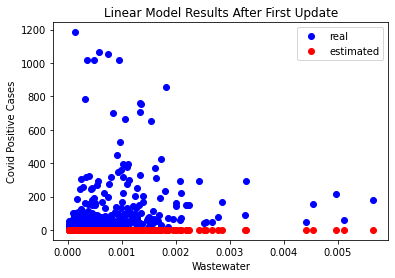

In [ ]:
# Use learning rate 

learning_rate = 100
# Update w and b and re-run the model
w.data = w.data - learning_rate * w.grad.data
b.data = b.data - 1e-2 * b.grad.data

linear_y = linear_model(p_x_var)
plt.title("Linear Model Results After First Update")
plt.xlabel("Wastewater")
plt.ylabel("Covid Positive Cases")
plt.plot(p_x_var.data.numpy(), p_y_var.data.numpy(), 'bo', label='real')
plt.plot(p_x_var.data.numpy(), linear_y.data.numpy(), 'ro', label='estimated')
plt.legend()

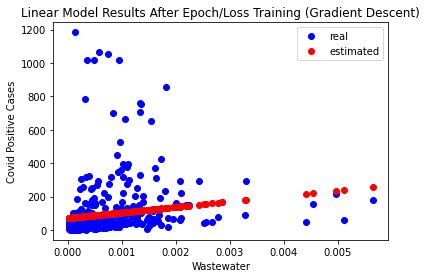

In [ ]:
# Preform updated 
for e in range(10000): # Update / Train the model by changing the bias and weights 
    linear_y = linear_model(p_x_var)
    loss = get_loss(linear_y, p_y_var)
    
    w.grad.zero_() # set w gradient to 0
    b.grad.zero_() # set b gradient to 0
    loss.backward()
    
    w.data = w.data - learning_rate * w.grad.data # update w
    b.data = b.data - 1e-2 * b.grad.data # update b 

linear_y = linear_model(p_x_var)
plt.title("Linear Model Results After Epoch/Loss Training (Gradient Descent)")
plt.xlabel("Wastewater")
plt.ylabel("Covid Positive Cases")
plt.plot(p_x_var.data.numpy(), p_y_var.data.numpy(), 'bo', label='real')
plt.plot(p_x_var.data.numpy(), linear_y.data.numpy(), 'ro', label='estimated')
plt.legend()

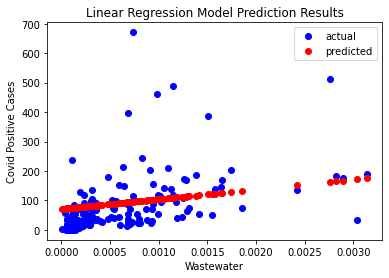

In [ ]:
# Make a predict based on x_test
predict = [float(w*i+b) for i in x_test]
plt.title("Linear Regression Model Prediction Results")
plt.xlabel("Wastewater")
plt.ylabel("Covid Positive Cases")
plt.plot(x_test, y_test, 'bo', label='actual')
plt.plot(x_test,predict,'ro',label = 'predicted')
plt.legend()

## Random Forest Regressor Model (SKLearn Library)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


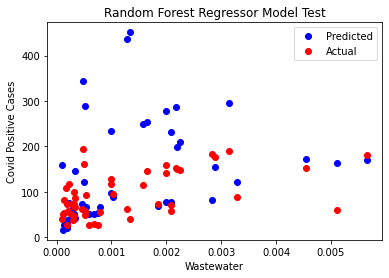

In [ ]:
# Format the data into something SKLearn will understand and convert to NumPy Arrays
inputs_ = []
targets_ = []
for i in waste3_covid: 
  inputs_.append([i[0], i[1]])
  targets_.append([i[2]])

inputs = np.array(inputs_,dtype='float32')
targets = np.array(targets_,dtype='float32')

# Train the data
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(inputs[:len(inputs)-50], targets[:len(inputs)-50]) 

# Preform the test by calling the prediction function
test_x = []
test_y = []
test_actual = []
for i in range(len(inputs)-50,len(inputs)):
  pred = regressor.predict(np.array([inputs[i]]))
  total = inputs[i][0] + inputs[i][1]
  test_x.append(total)  
  test_y.append(pred)  
  test_actual.append(targets[i])

# Plot the results 
plt.title("Random Forest Regressor Model Test")
plt.xlabel("Wastewater")
plt.ylabel("Covid Positive Cases")
plt.plot(test_x, test_y, 'bo', label='Predicted')
plt.plot(test_x, test_actual, 'ro', label='Actual')
plt.legend()